# Uncalibrated photometric stereo constrained by intrinsic reﬂectance image and shape from silhoutte

In [1]:
import cv2

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from Renderer import render_depth_map

In [2]:
DATASET_PATH = "../Data/Dataset/"
# DATASET_PATH = "../../GroupWork-Private/PSData/cat/Objects/"

## 3.1 Load Images

In [3]:
# load all images from the dataset
images = []
for img_path in Path(DATASET_PATH).glob("*.png"):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0 # normalize images from [0, 255] to [0, 1]
    images.append(img)
images = np.array(images)
print('Images shape:', images.shape) # (num_images, width, height)

# define number of images, width and height
num_images, width, height = images.shape
print('Number of images:', num_images)
print('Image dimensions (width x height):', width, 'x', height)

# define total number of pixels in an image (P)
P = height * width
print('Total number of pixels (P):', P, 'pixels')

Images shape: (20, 640, 500)
Number of images: 20
Image dimensions (width x height): 640 x 500
Total number of pixels (P): 320000 pixels


## 3.2 Estimate of the Albedo

In [4]:
# compute the average image
average_image = np.mean(images, axis=0)

# apply a bilateral filter to the average image
# the default parameters from OpenCV are used: https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed
albedo_estimate = cv2.bilateralFilter(average_image.astype(np.float32), d=9, sigmaColor=75, sigmaSpace=75)

# reshape the albedo estimate to width x height x (gray scale channel)
albedo_estimate = albedo_estimate.reshape((width, height, -1))
print('Albedo estimate shape:', albedo_estimate.shape)

Albedo estimate shape: (640, 500, 1)


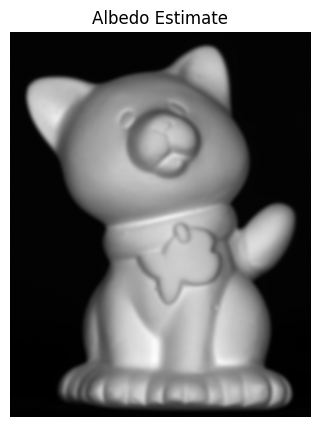

In [5]:
# visualize the albedo estimate
plt.figure(figsize=(5, 5))
plt.imshow(albedo_estimate, cmap='gray')
plt.axis('off')

# save the albedo estimate
plt.savefig("../Report/IMG/res-01-albedo.png", bbox_inches="tight", pad_inches=0)

plt.title('Albedo Estimate')
plt.show()

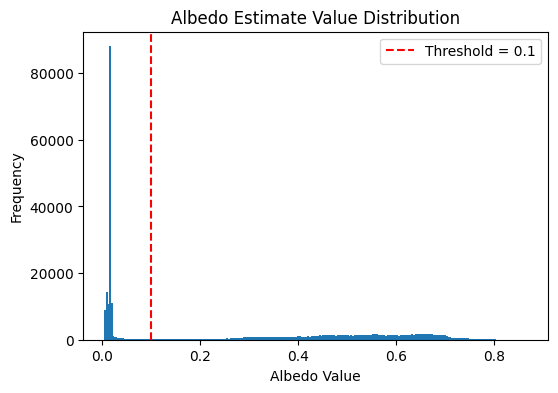

In [6]:
# define a threshold for albedo values
THRESHOLD = 0.1

# visualize the albedo estimate value distribution to define a threshold
plt.figure(figsize=(6, 4))
plt.hist(albedo_estimate.ravel(), bins=256)
plt.axvline(x=THRESHOLD, color='r', linestyle='--', label=f'Threshold = {THRESHOLD}')
plt.title('Albedo Estimate Value Distribution')
plt.xlabel('Albedo Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 3.3 Singular Value Decomposition (SVD)

In [7]:
# define the image matrix using the images
I = np.zeros((num_images, P), dtype=np.float32)
for i in range(num_images):
    I[i, :] = images[i].ravel()
print('Image matrix shape (I):', I.shape)

Image matrix shape (I): (20, 320000)


In [8]:
# compute the thresholded albedo mask, this mask is used to ignore low albedo pixels (pixels with a low brightness value) (see equation 6 in the paper)
albedo_mask_2D = albedo_estimate > THRESHOLD
albedo_mask_1D = albedo_mask_2D.ravel()
print('Albedo mask 2D shape:', albedo_mask_2D.shape)
print('Albedo mask 1D shape:', albedo_mask_1D.shape)

# define the number of non-thresholded pixels (P_tilde)
P_tilde = np.count_nonzero(albedo_mask_2D)
print('Total number of non-thresholded pixels (P_tilde):', P_tilde, 'pixels')

Albedo mask 2D shape: (640, 500, 1)
Albedo mask 1D shape: (320000,)
Total number of non-thresholded pixels (P_tilde): 178529 pixels


In [ ]:
# compute the shading matrix pixels
shading_matrix = np.full((num_images, P_tilde), np.nan, dtype=np.float32) # initialize shading matrix with NaN values
for i in range(num_images):
    # set the shading values for all non-thresholded pixels (values where the albedo is high enough) (see equation 5 in the paper)
    shading_matrix[i, :] = I[i][albedo_mask_1D] / albedo_estimate[albedo_mask_2D]
print('Shading matrix shape:', shading_matrix.shape)

# compute the image matrix (I_tilde)
I_tilde = shading_matrix.T  # transpose the shading matrix, such that images are in the last dimension
print('Image matrix shape (I_tilde):', I_tilde.shape)

Shading matrix shape: (20, 178529)
Image matrix shape (I_tilde): (178529, 20)


In [ ]:
def svd_uwvt(A, k=3):
    """
    Singular Value Decomposition with singular value thresholding

    Args:
        A (np.ndarray): input matrix
        k (int): number of singular values to keep

    Returns:
        U_k (np.ndarray): left singular matrix (P x k)
        W_k (np.ndarray): diagonal matrix with top k singular values (k x k)
        Vt_k (np.ndarray): right singular matrix (k x N)
    """

    # singular value decomposition
    U, s, Vt = np.linalg.svd(A, full_matrices=False)

    # keep only top k singular values
    U_k = U[:, :k]          # shape: (P, 3)
    W_k = np.diag(s[:k])    # shape: (3, 3)
    Vt_k = Vt[:k, :]        # shape: (3, N)

    return U_k, W_k, Vt_k

# singular value decomposition (SVD) of the image matrix
U_prime, W_prime, Vt_prime = svd_uwvt(I_tilde, k=3) # keep only top 3 singular values (x, y, z components, the rest is noise)
print('Left singular matrix shape (U_prime):', U_prime.shape)
print('Diagonal matrix shape (W_prime):', W_prime.shape)
print('Right singular matrix shape (Vt_prime):', Vt_prime.shape)

Left singular matrix shape (U_prime): (178529, 3)
Diagonal matrix shape (W_prime): (3, 3)
Right singular matrix shape (Vt_prime): (3, 20)


In [ ]:
# compute the pseudo surface and light matrices (S_prime and L_prime) from the SVD components (see equation 10 in the paper)
S_prime = U_prime
L_prime = np.dot(W_prime, Vt_prime) # Vt_prime is already transposed
print('Pseudo surface matrix shape (S_prime):', S_prime.shape)
print('Pseudo light matrix shape (L_prime):', L_prime.shape)

Pseudo surface matrix shape (S_prime): (178529, 3)
Pseudo light matrix shape (L_prime): (3, 20)


## 3.4 Constant Albedo Constraint

In [ ]:
# define indexes for the 3 components (x, y and z)
x_idx = 0
y_idx = 1
z_idx = 2

# compute the matrix C using the pseudo surface matrix (see equation 15 in the paper)
C = np.zeros((P_tilde, 6), dtype=np.float32)
C[:, 0] = S_prime[:, x_idx] ** 2
C[:, 1] = S_prime[:, y_idx] ** 2
C[:, 2] = S_prime[:, z_idx] ** 2
C[:, 3] = 2 * S_prime[:, x_idx] * S_prime[:, y_idx]
C[:, 4] = 2 * S_prime[:, y_idx] * S_prime[:, z_idx]
C[:, 5] = 2 * S_prime[:, z_idx] * S_prime[:, x_idx]
print('C matrix shape:', C.shape)

C matrix shape: (178529, 6)


In [ ]:
# define ones vector (see equation 16 in the paper)
ones_vector = np.ones((P_tilde), dtype=np.float32).T

# compute b values (see equation 17 in the paper)
b = np.dot(np.linalg.pinv(C), ones_vector)
print('b vector shape:', b.shape)
print('b values:', b)

# define the B matrix using the b values (see equation 13 in the paper)
B = np.array([[b[0], b[3], b[5]],
              [b[3], b[1], b[4]],
              [b[5], b[4], b[2]]], dtype=np.float32)

b vector shape: (6,)
b values: [ 1.7831162e+05 -4.5078946e+02 -5.4886163e+02 -7.3780823e+02
 -6.9182449e+01  9.1794122e+02]


In [ ]:
# singular value decomposition of the B matrix
U_B, W_B, Vt_B = svd_uwvt(B, k=3)

# compute the ambiguity matrix A (see equation 19 in the paper)
A = np.dot(U_B, np.sqrt(W_B))
print('Ambiguity matrix shape (A):', A.shape)

Ambiguity matrix shape (A): (3, 3)


In [ ]:
# compute the second pseudo surface and light matrices (S_2prime and L_2prime) from the SVD components (see equation 20 in the paper)
S_2prime = np.dot(S_prime, A)
L_2prime = np.dot(np.linalg.inv(A), L_prime)
print('Second pseudo surface matrix shape (S_2prime):', S_2prime.shape)
print('Second pseudo light matrix shape (L_2prime):', L_2prime.shape)

Second pseudo surface matrix shape (S_2prime): (178529, 3)
Second pseudo light matrix shape (L_2prime): (3, 20)


## 3.5 Constraint using Guide Normal

In [ ]:
def compute_guide_normal(albedo_estimate, albedo_threshold):
    """
    Compute the guide normal from the albedo estimate

    Args:
        albedo_estimate (np.ndarray): albedo estimate (width x height x channels)
        albedo_threshold (float): threshold for albedo values

    Returns:
        guide_normal (np.ndarray): guide normal (width x height x 3)
    """
    # 1. compute the silhouette image from the albedo estimate using the albedo threshold
    # the silhouette image is a binary mask where the values above the threshold are set to 1 and the values below the threshold are set to 0
    silhouette_image = (albedo_estimate > albedo_threshold).astype(np.uint8)

    # 2. compute the approximate shape from the silhouette image using a distance transform
    # the approximate shape is a height map where the center of the object is high (1) and the edges are low (0)
    approximate_shape = cv2.distanceTransform(silhouette_image, distanceType=cv2.DIST_L2, maskSize=5)

    # 3. normalize the approximate shape
    # the approximate shape is normalized to the range [0, image width/2] to prevent extreme gradients
    if approximate_shape.max() > 0:
        approximate_shape = cv2.normalize(approximate_shape, None, alpha=0, beta=(silhouette_image.shape[1] / 2), norm_type=cv2.NORM_MINMAX)

    # 4. compute the gradients of the approximate shape
    # the gradients represent the change in height in the x and y directions
    dz_dy, dz_dx = np.gradient(approximate_shape)

    # 5. compute the guide normal from the gradients
    # the gradients are negated because if the slope is positive, the normal points should point downwards
    guide_normal = np.dstack((-dz_dx, -dz_dy, np.ones_like(approximate_shape)))

    # 6. normalize the guide normal vectors to make them unit length
    norm = np.linalg.norm(guide_normal, axis=2, keepdims=True)
    guide_normal = np.divide(guide_normal, norm, where=(norm != 0))

    # 7. mask out the background pixels in the guide normal
    guide_normal[albedo_estimate <= albedo_threshold] = 0

    return guide_normal, silhouette_image, approximate_shape

# compute the guide normal from the albedo estimate
guide_normal, silhouette_image, approximate_shape = compute_guide_normal(average_image, THRESHOLD)

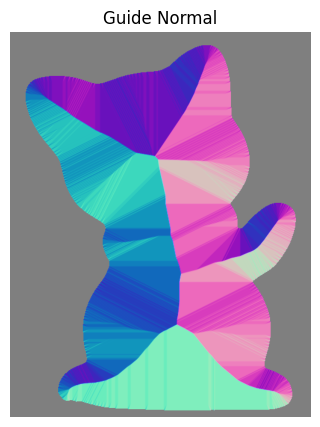

In [ ]:
# visualize the guide normal
plt.figure(figsize=(5, 5))
plt.imshow((guide_normal + 1) / 2)  # normalize from [-1, 1] to [0, 1] for visualization
plt.axis('off')

# save the guide normal
plt.savefig("../Report/IMG/res-04-guide-normal.png", bbox_inches="tight", pad_inches=0)

plt.title('Guide Normal')
plt.show()

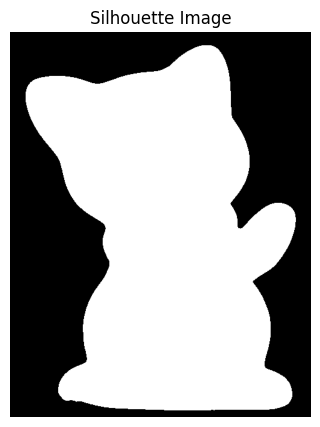

In [ ]:
# visualize the silhouette image
plt.figure(figsize=(5, 5))
plt.imshow(silhouette_image, cmap='gray')
plt.axis('off')

# save the silhouette image
plt.savefig("../Report/IMG/res-02-silhouette.png", bbox_inches="tight", pad_inches=0)

plt.title('Silhouette Image')
plt.show()

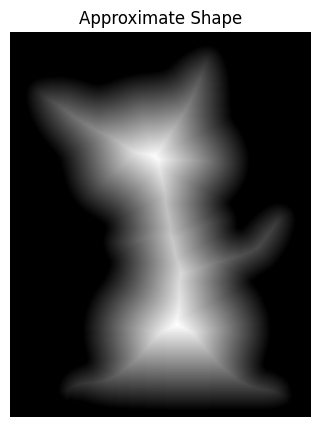

In [ ]:
# visualize the approximate shape
plt.figure(figsize=(5, 5))
plt.imshow(approximate_shape, cmap='gray')
plt.axis('off')

# save the approximate shape
plt.savefig("../Report/IMG/res-03-approximate-shape.png", bbox_inches="tight", pad_inches=0)

plt.title('Approximate Shape')
plt.show()

In [ ]:
# compute the guide normal matrix (S_tilde) from the guide normal
S_tilde = guide_normal.reshape(-1, 3)[albedo_mask_1D]
print('Guide normal matrix shape (S_tilde):', S_tilde.shape)

Guide normal matrix shape (S_tilde): (178529, 3)


In [ ]:
# compute the ambiguity orthogonal matrix R (see equation 23 in the paper)
R = np.dot(np.linalg.pinv(S_2prime), S_tilde)

# compute the orthogonal matrix R_tilde by orthogonalizing R
R_tilde, _= np.linalg.qr(R) # the orthogonal matrix R_tilde can be obtained by taking the Q matrix from the QR decomposition of R

In [ ]:
# compute the partial surface and light matrices (S_partial and L) (see equation 24 in the paper)
S_partial = np.dot(S_2prime, R_tilde)
L = np.dot(np.linalg.inv(R_tilde), L_2prime)

## Final output 

In [ ]:
# recompute the full surface matrix using the light matrix and the original image matrix (see equation 4 in the paper)
S = np.dot(I.T, np.linalg.pinv(L)) 
print('Final surface matrix shape (S):', S.shape)

Final surface matrix shape (S): (320000, 3)


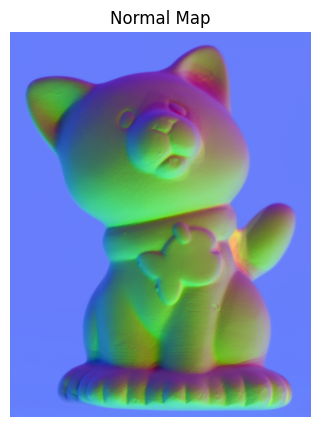

In [ ]:
# normalize the surface matrix S to get the normal map
S_min = S.min(axis=(0), keepdims=True)
S_max = S.max(axis=(0), keepdims=True)
S_normalized = ((S - S_min) / (S_max - S_min))

# visualize the normal map
plt.figure(figsize=(5, 5))
plt.imshow(S_normalized.reshape((width, height, 3)))
plt.axis('off')

# save the normal map
plt.savefig("../Report/IMG/res-05-normal-map.png", bbox_inches="tight", pad_inches=0)

plt.title('Normal Map')
plt.show()

In [ ]:
# compute the depth map from the surface matrix using the Frankot-Chellappa algorithm
def frankot_chellappa(surface_normals):
    """
    Reconstruct depth map (Z) from surface normals using the Frankot-Chellappa algorithm.

    Parameters:
        surface_normals (numpy.ndarray): unnormalized surface normals of shape (H, W, 3).

    Returns:
        depth_map (numpy.ndarray): reconstructed depth map of shape (H, W).
    """

    # 1. get gradients from surface normals (dx, dy, dz)
    dx, dy, dz = surface_normals[:, :, 0], surface_normals[:, :, 1], surface_normals[:, :, 2]

    # 2. compute p = -dx/dz and q = -dy/dz
    p = np.divide(-dx, dz, where=(dz != 0)) # avoid division by zero
    q = np.divide(-dy, dz, where=(dz != 0)) # avoid division by zero

    # 3. mask out background (where normals are zero)
    mask = (dz != 0).astype(float)
    p *= mask
    q *= mask

    # 4. Fourier transform of gradients p and q
    p_fft = np.fft.fft2(p)
    q_fft = np.fft.fft2(q)

    # 5. create frequency grid
    num_rows, num_cols = p.shape
    wx, wy = np.meshgrid(
        np.fft.fftfreq(num_cols) * 2 * np.pi,
        np.fft.fftfreq(num_rows) * 2 * np.pi
    )

    # 6. integrate in the frequency domain
    # equation: Z_hat = (-j * wx * P - j * wy * Q) / (wx^2 + wy^2)
    # the term (wx^2 + wy^2) acts as an inverse Laplacian filter
    numerator = -1j * wx * p_fft - 1j * wy * q_fft
    denominator = wx**2 + wy**2
    denominator[0, 0] = 1.0 # avoid division by zero at denominator component (0, 0)
    Z_hat = numerator / denominator
    Z_hat[0, 0] = 0 # force that the mean height is 0

    # 7. inverse Fourier transform to get Z
    Z = np.real(np.fft.ifft2(Z_hat))

    # 8. apply mask to Z
    depth_map = Z * mask

    return depth_map

# compute the depth map from the surface matrix, we don't need to use the normalized surface matrix, as the depth is computed from the unnormalized surface normals
depth_map = frankot_chellappa(S.reshape((width, height, 3)))

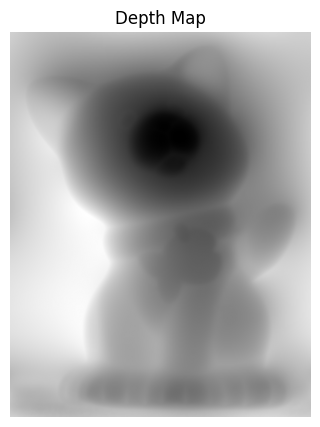

In [ ]:
# visualize the depth map
plt.figure(figsize=(5, 5))
plt.imshow(depth_map, cmap='gray')
plt.axis('off')

# save the depth map
plt.savefig("../Report/IMG/res-06-depth-map.png", bbox_inches="tight", pad_inches=0)

plt.title('Depth Map')
plt.show()

In [ ]:
# render the depth map with the albedo estimate as texture in a 3D viewer
render_depth_map(depth_map, albedo_estimate, THRESHOLD)